In [1]:
import sys 
import io
import os
import cv2
import itertools

In [2]:
import matplotlib.pyplot as plt
import seaborn as sbn
import pandas as pd
import numpy as np
import random

In [37]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow.keras.layers as layers
import tensorflow.keras as keras
import tensorflow as tf

In [4]:
plt.style.use('seaborn-darkgrid')

# 1. Vamos a comenzar con la exploración de los datos. 

Tengo al momento tres data sets, cada uno con sus carateristicas:
* [Data Set Mateusz Buda](https://www.kaggle.com/mateuszbuda/lgg-mri-segmentation)
* [Data Set Sartaj](https://www.kaggle.com/sartajbhuvaji/brain-tumor-classification-mri)
* [Data Set Navoneel](https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection)

Vamos a realizar los análisis por serparado. 

Es muy imporante notar que no tienen en principio caracteristicas entre los conjutos de datos. La razón de tenerlos será o bien buscar una forma de poder crear un data set más grande o bien buscar el set de datos que cubra las necesidades del proyecto. 

## 1.1 Set de Sartaj

La estructura del data set de Sartaj es la siguiente:
```
.
|
└───data
    │
    └───brain_MRI_Sartaj
        │
        |───Training
        │   │   
        │   │───pituitary_tumor
        |   |   |   p*.jpg
        |   │   │   ...
        |   |
        |   |───no_tumor
        |   |   |   image*.jpg
        |   │   │   ...
        |   |
        |   |───glioma_tumor
        |   |   |   gg*.jpg
        |   │   │   ...
        |   |
        |   └───meningioma_tumor
        |       |   m1*.jpg
        |       │   ...
        |
        └───Training
            │   
            │───pituitary_tumor
            |   |   p*.jpg
            │   │   ...
            |
            |───no_tumor
            |   |   image*.jpg
            │   │   ...
            |
            |───glioma_tumor
            |   |   gg*.jpg
            │   │   ...
            |
            └───meningioma_tumor
                |   m1*.jpg
                │   ...
    
    

```
Vamos a realizar el análsis explotario con los datos de Trainig.

En lugar de hacer un symlink prefiero usar varibles para guardar los paths absolutos.

In [5]:
#Este es nuestro directorio Training
MAINFOLDER = '../data/brain_MRI_Sartaj/Training/' 

In [6]:
#Acá itearmos para obtener los subdirectios de Training
SUBDIRS = os.listdir(MAINFOLDER)

In [7]:
def load_images_from_folder(folder,verbose=0,color=1):
    """
    Esta función toma un path e itera sobre los
    elementos del path para leer imágenes
    
    
    """
    images,not_images = [],[]
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename),color)
        if img is not None:
            images.append(img)
        else:
            not_images.append(filename)
    if verbose !=0:
        print('{} tiene {} archivos que no son imágenes'.format(folder,len(not_images)))
    return images

In [8]:
# Acá cargamos las imágenes a color
imgs = {} #En este diccionario vamos a guardar los objetos images dentro de una lista y como key su parent folder
for i in SUBDIRS:
    imgs[i] = load_images_from_folder(MAINFOLDER+i,1) #Marcamos Verbose = 1 para ver si se coló algún archivo que no era imagen

../data/brain_MRI_Sartaj/Training/pituitary_tumor tiene 0 archivos que no son imágenes
../data/brain_MRI_Sartaj/Training/no_tumor tiene 0 archivos que no son imágenes
../data/brain_MRI_Sartaj/Training/glioma_tumor tiene 0 archivos que no son imágenes
../data/brain_MRI_Sartaj/Training/meningioma_tumor tiene 0 archivos que no son imágenes


In [9]:
# Acá cargamos las imágenes a blanco y negro
imgs_bw = {} #En este diccionario vamos a guardar los objetos images dentro de una lista y como key su parent folder
for i in SUBDIRS:
    imgs_bw[i] = load_images_from_folder(MAINFOLDER+i,verbose=1,color=0) #Marcamos Verbose = 1 para ver si se coló algún archivo que no era imagen y Color=0 para B&W

../data/brain_MRI_Sartaj/Training/pituitary_tumor tiene 0 archivos que no son imágenes
../data/brain_MRI_Sartaj/Training/no_tumor tiene 0 archivos que no son imágenes
../data/brain_MRI_Sartaj/Training/glioma_tumor tiene 0 archivos que no son imágenes
../data/brain_MRI_Sartaj/Training/meningioma_tumor tiene 0 archivos que no son imágenes


Ahora, vamos a realizar una cuadricula para ver un sampling de las imágenes que están dentro de nuestros set de training

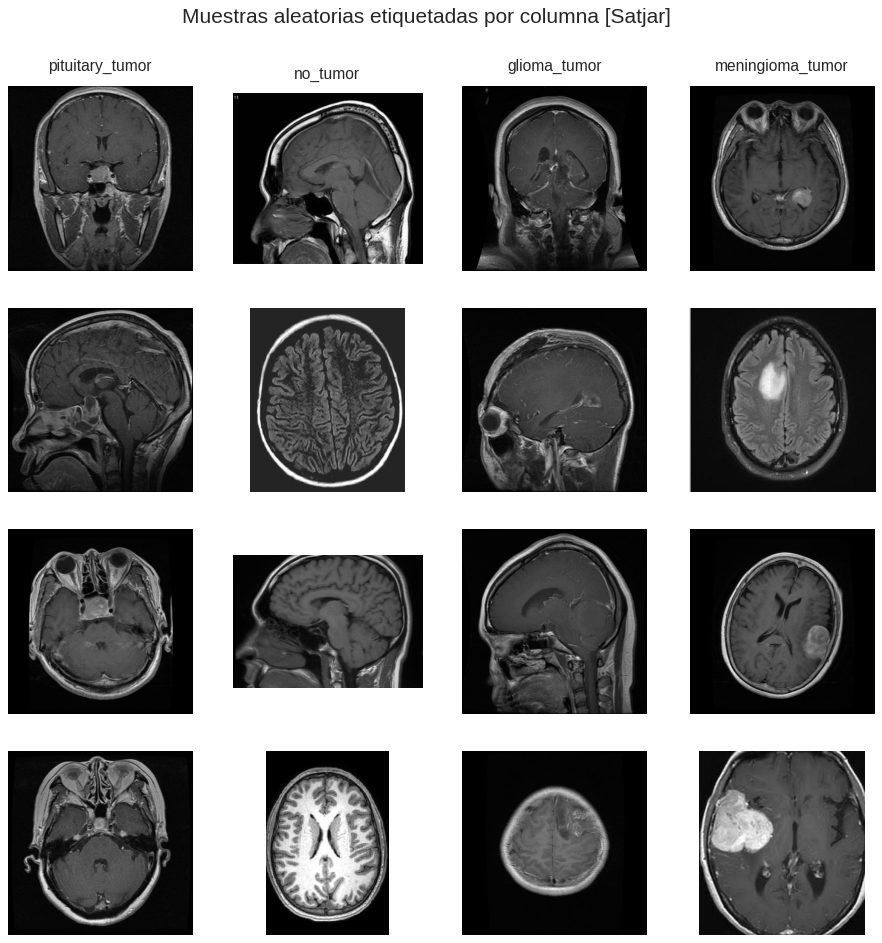

In [10]:
fig, ax = plt.subplots(4,4,figsize=(15,15),dpi=75)
for i,key in enumerate(imgs.keys()):
    for j,im in enumerate(random.choices(population=imgs[key],k=4)):
        ax[j,i].imshow(im)
        #ax[j,i].set_title(key)
        ax[j,i].set_axis_off()
        ax[0][i].set_title(key,fontsize=15).set_position([.5, 1.05])
        
fig.suptitle('Muestras aleatorias etiquetadas por columna [Satjar]',y=0.95,fontsize=20)
        
plt.show()

Una discusión que se puede desarrollar es si están bien etiquetadas las imágenes. De no estar así puede llevarnos a que el modelo aprenda _spurious patterns_ y nunca converger o bien overfitting -entre más outliers existan dentro de una misma clase más difícil será crear un modelo general ya que para poder capturarlos las fronteras de desición se tiene que extender o bien desarrollar extensiones para cubrir esos púntos específicos-

Ahora bien, vamos a ver que tan balanceada está la data de cada conjunto.

In [11]:
dummy = {'category':[], 'size':[]}
for i in imgs.keys():
    dummy['category'].append(i)
    dummy['size'].append(len(imgs[i]))

In [12]:
df = pd.DataFrame(dummy)

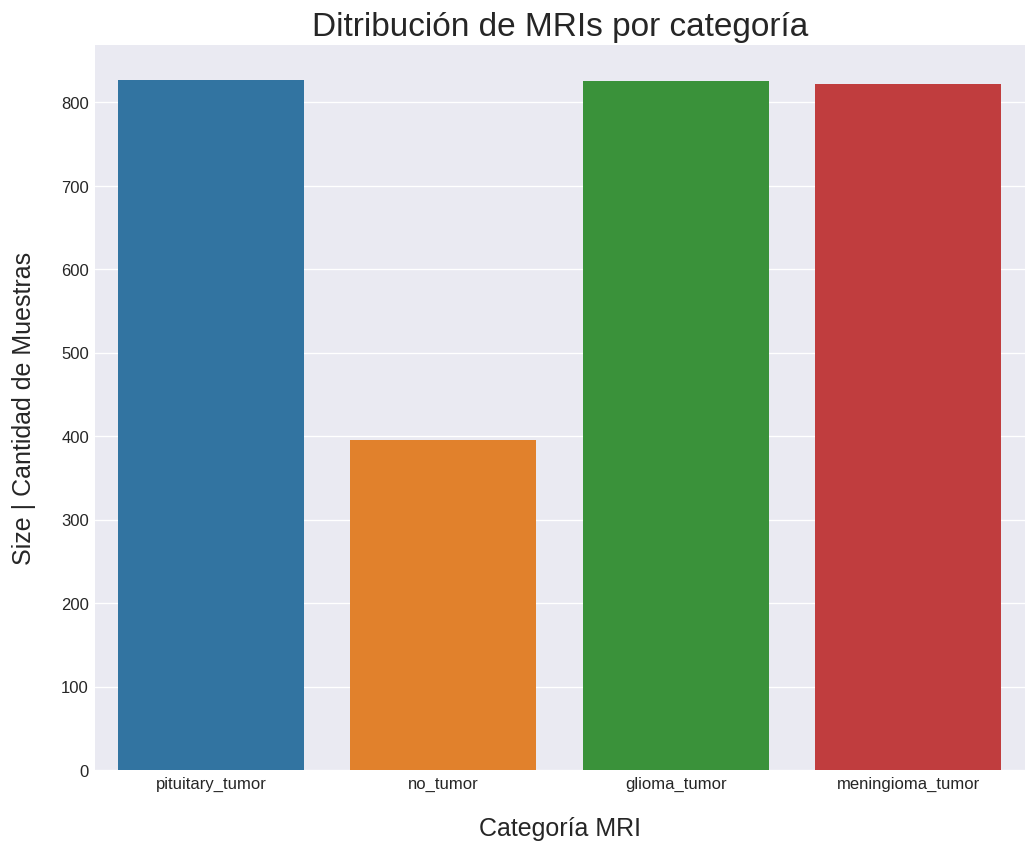

In [13]:
fix,ax = plt.subplots(1,1,dpi=120,figsize=(10,8))
sbn.barplot(
    data = df,
    x = 'category',
    y = 'size',
    ax = ax
)
ax.set_title('Ditribución de MRIs por categoría',fontsize=20)
ax.set_ylabel('Size | Cantidad de Muestras',fontsize=15,labelpad=15)
ax.set_xlabel('Categoría MRI',fontsize=15,labelpad=15)


plt.show()

Es importante notar que estamos frente a un problema de **Imbalanced Data** (ratio ~2:1). Afortunadamente para la parte de clasificación vamos a poder usar algunos métodos ya conocidos, para una revesión se recomienda la entrada del blog _Machine Learning Mastery_ [A Gentle Introduction to Imbalanced Classification](https://machinelearningmastery.com/what-is-imbalanced-classification/)

Otra cosa que será bastante importante es revisar la distribución de tamaños de las imágenes de cada categoría. Es recomendable simple realizar un resize pero por lo pronto vamos a ver cómo se distribuyen los tamaños de los MRIs.

In [14]:
sizes = lambda x: [str(i.shape[0])+'x'+str(i.shape[1]) for i in x]

In [15]:
dummy = {'category':[],'sizes':[]}
for i in imgs.keys():
    dummy['category'] = dummy['category'] + [i]*len(imgs[i])
    dummy['sizes'] = dummy['sizes'] + sizes(imgs[i])

In [16]:
df = pd.DataFrame(dummy)
df['dummy'] = 1
df_dummy = df.groupby(['category','sizes']).agg({'dummy':'sum'}).reset_index()

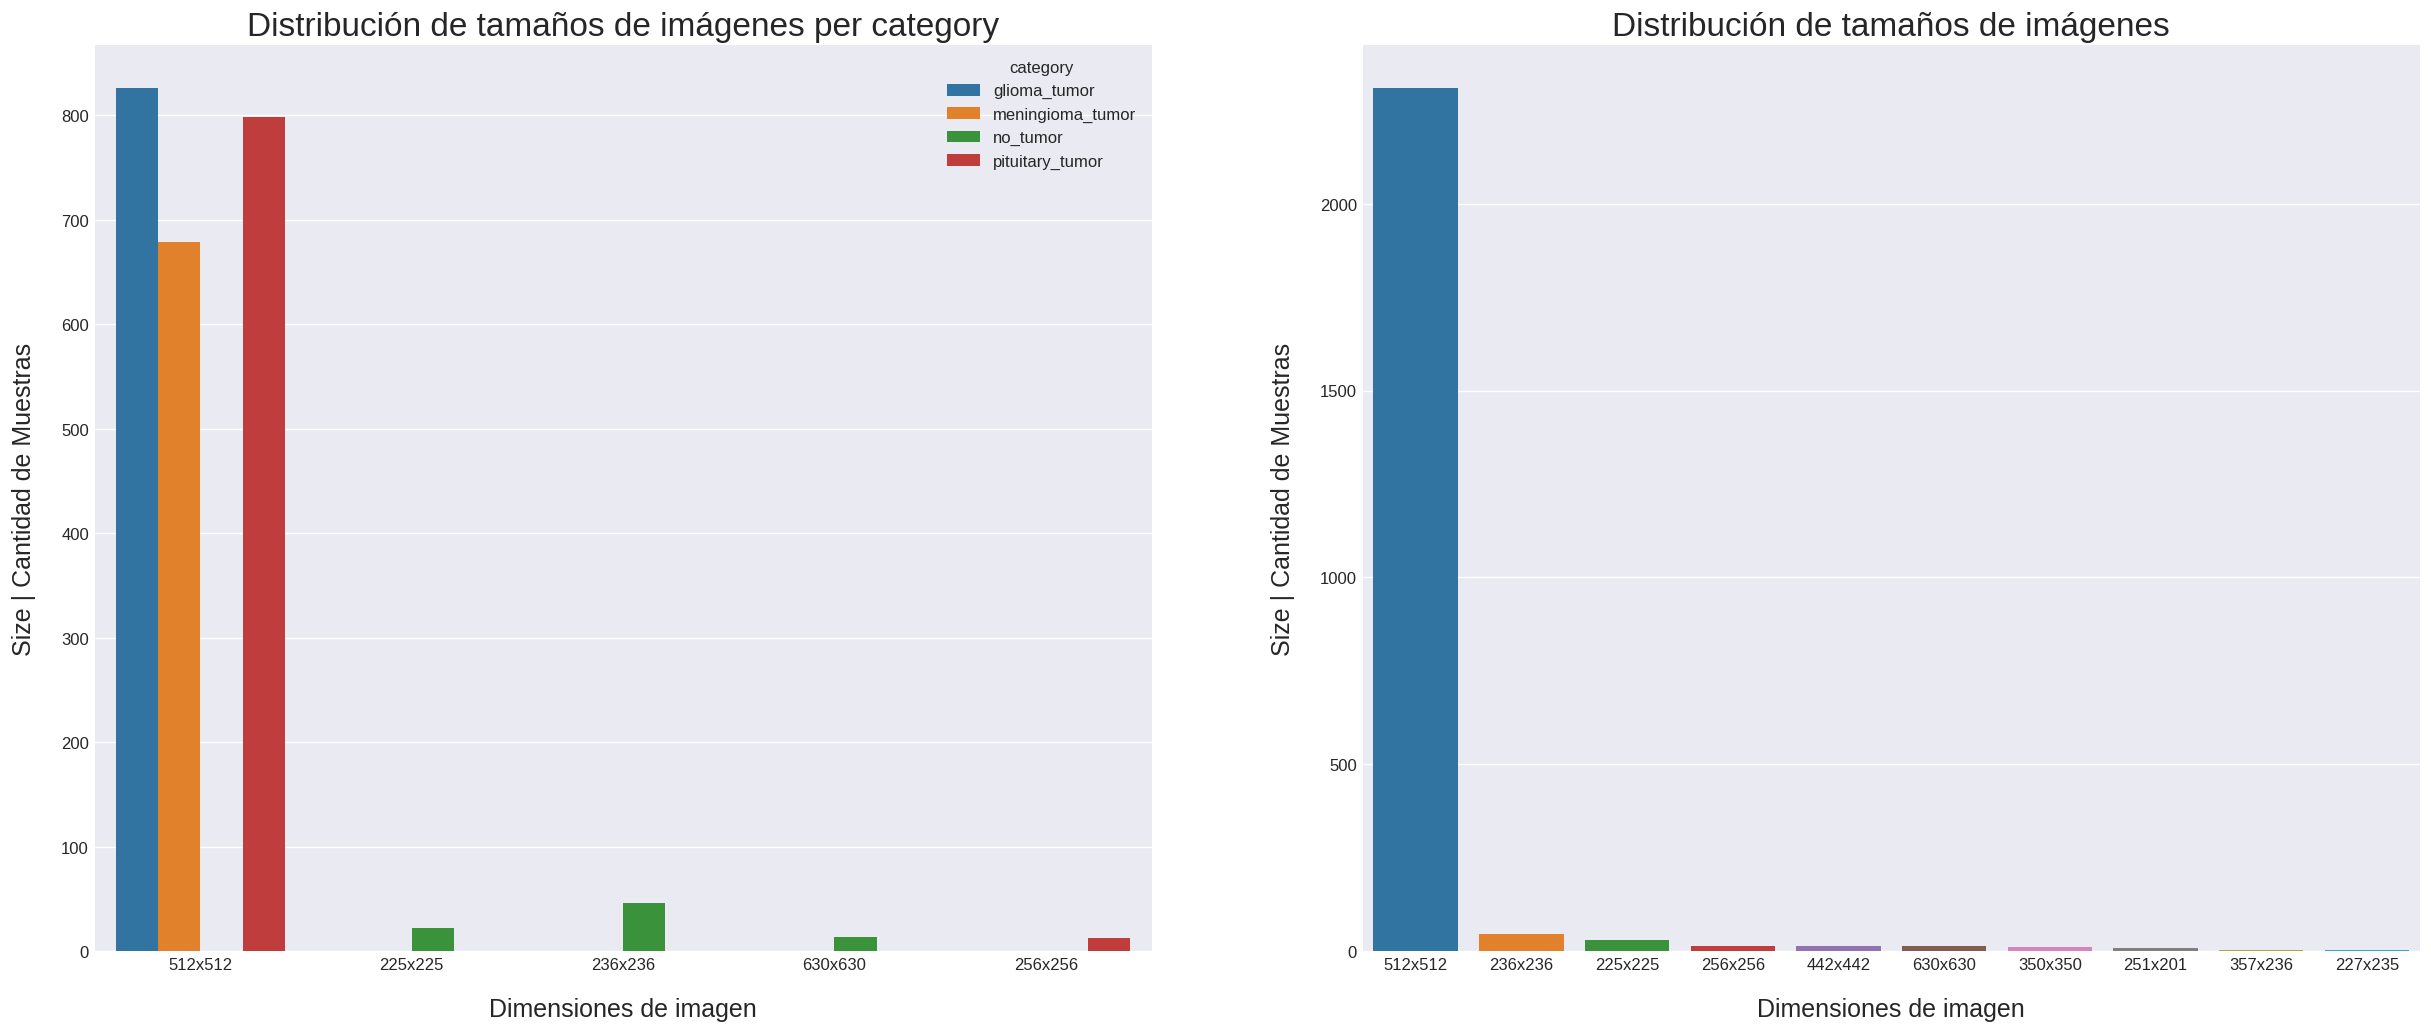

In [17]:
fix,ax = plt.subplots(1,2,dpi=120,figsize=(25,10))
sbn.barplot(
    data = df_dummy[df_dummy.dummy>10],
    x = 'sizes',
    y = 'dummy',
    hue = 'category',
    ax = ax[0]
)
ax[0].set_title('Distribución de tamaños de imágenes per category',fontsize=20)
ax[0].set_ylabel('Size | Cantidad de Muestras',fontsize=15,labelpad=15)
ax[0].set_xlabel('Dimensiones de imagen',fontsize=15,labelpad=15)

sbn.barplot(
    x = df.sizes.value_counts().index.values[:10],
    y = df.sizes.value_counts().values[:10],
    ax=ax[1]
)
ax[1].set_title('Distribución de tamaños de imágenes',fontsize=20)
ax[1].set_ylabel('Size | Cantidad de Muestras',fontsize=15,labelpad=15)
ax[1].set_xlabel('Dimensiones de imagen',fontsize=15,labelpad=15)


plt.show()

Lo anterior nos deja claro que nos solamente tenemos las categorías desbalanceadas sino también los tamaños. Afortunadamete esto es más sencillo de hacer que lidiar con los datos no balanceados. 

In [18]:
def resize(array,he=250,wi=250):
    """
    This function resizes an array of cv2.imread files
    to he x wi images. It does not matter if they were
    read using cv2.IMREAD_COLOR, cv2.IMREAD_GRAYSCALE
    or cv2.IMREAD_UNCHANGED
    
    Parameters
    ----------
    array : list, numpy.narray, tuple, set
        Array of cv2.imread files
    he : int
        Height of resised image
    wi : int
        Width of resised image
        
    Returns
    -------
    array
    An array of cv2.imread files resised to he x wi
    """
    return [cv2.resize(img,(he,wi)) for img in array]

In [19]:
for i in imgs.keys():
    imgs[i] = resize(imgs[i])

In [20]:
dummy = {'category':[],'sizes':[]}
for i in imgs.keys():
    dummy['category'] = dummy['category'] + [i]*len(imgs[i])
    dummy['sizes'] = dummy['sizes'] + sizes(imgs[i])
    
df = pd.DataFrame(dummy)
df['dummy'] = 1
df_dummy = df.groupby(['category','sizes']).agg({'dummy':'sum'}).reset_index()

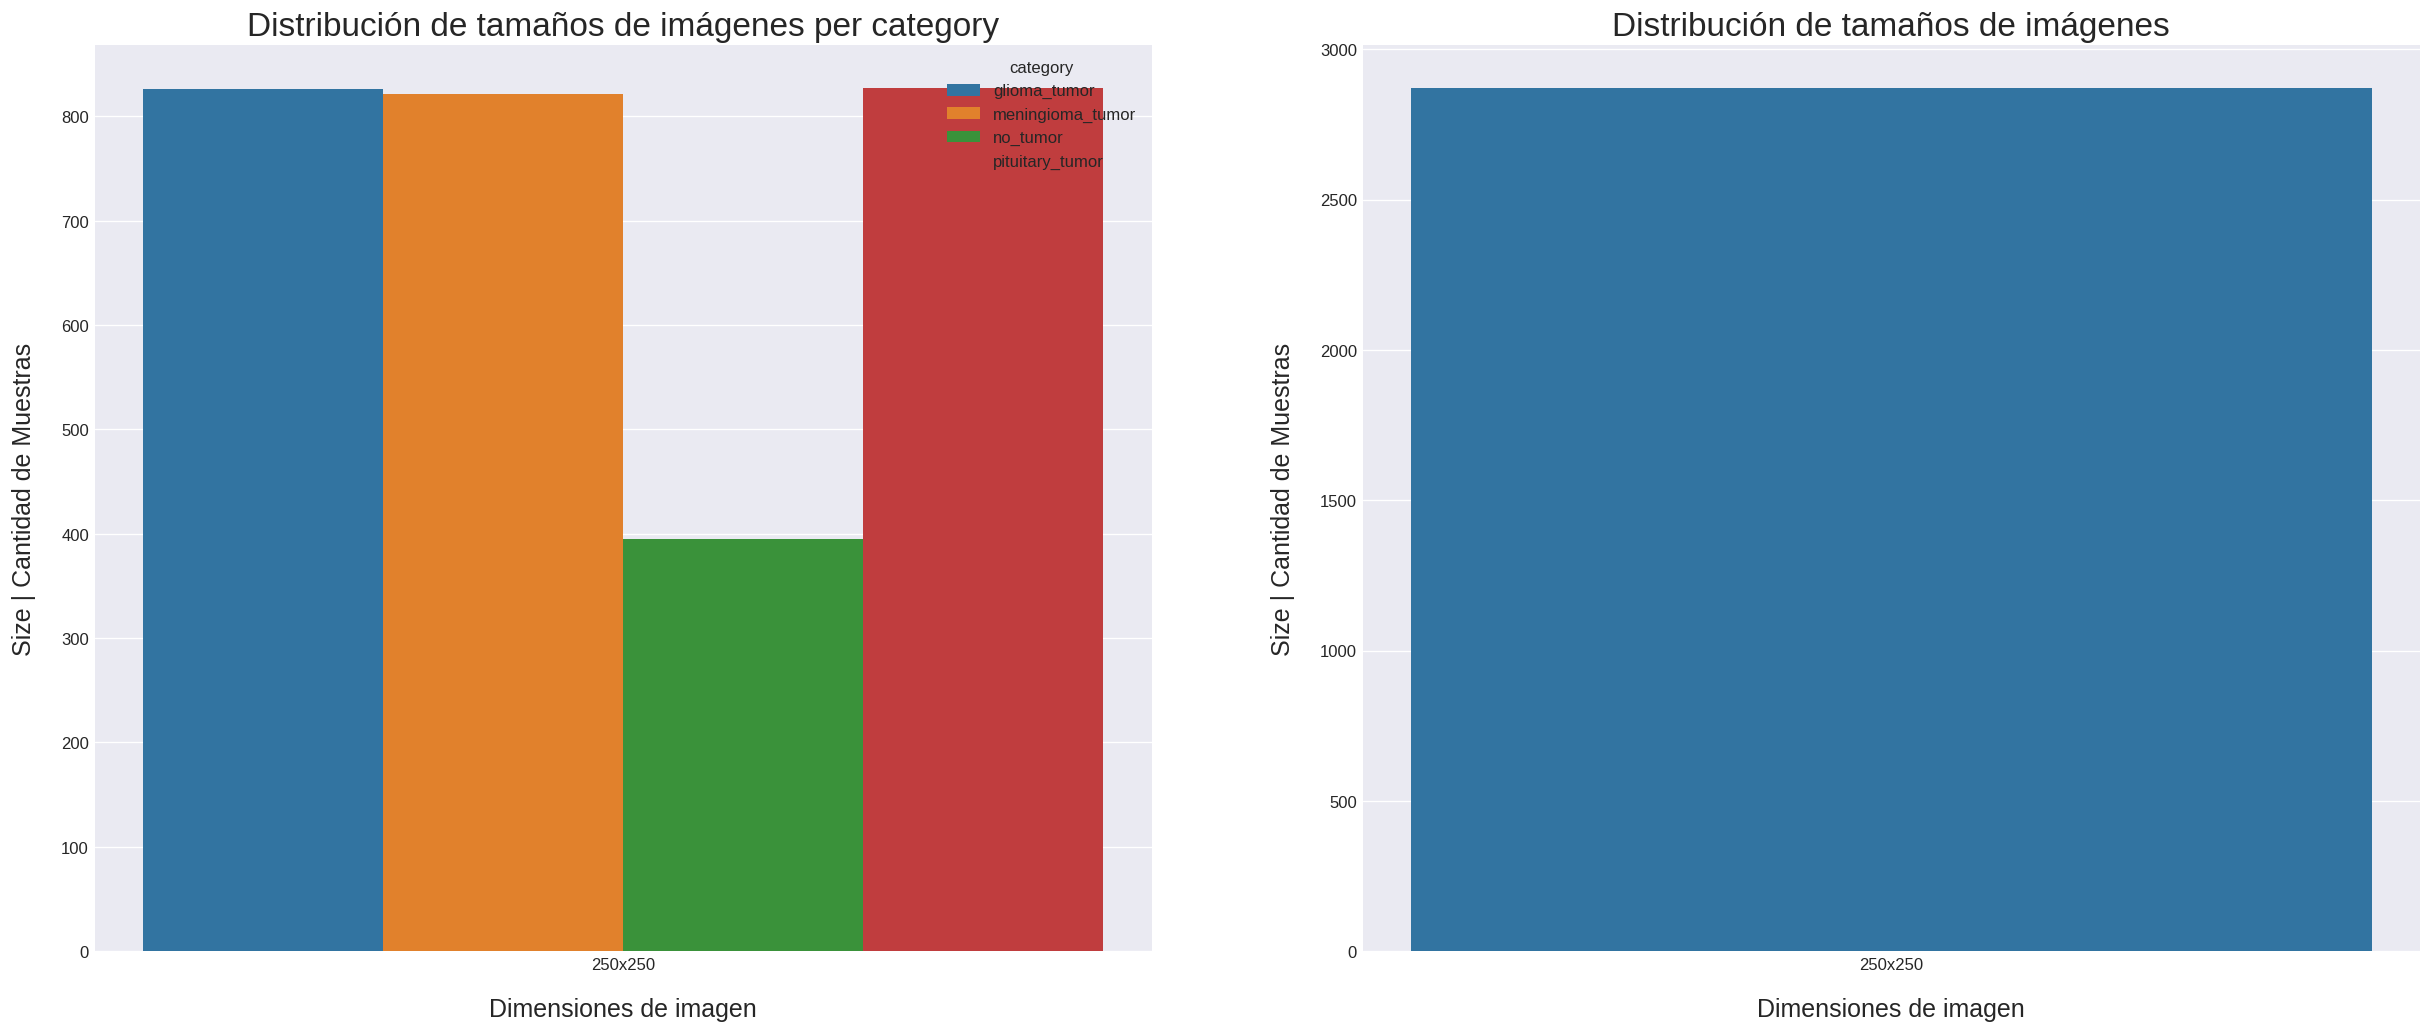

In [21]:
fix,ax = plt.subplots(1,2,dpi=120,figsize=(25,10))
sbn.barplot(
    data = df_dummy[df_dummy.dummy>10],
    x = 'sizes',
    y = 'dummy',
    hue = 'category',
    ax = ax[0]
)
ax[0].set_title('Distribución de tamaños de imágenes per category',fontsize=20)
ax[0].set_ylabel('Size | Cantidad de Muestras',fontsize=15,labelpad=15)
ax[0].set_xlabel('Dimensiones de imagen',fontsize=15,labelpad=15)

sbn.barplot(
    x = df.sizes.value_counts().index.values[:10],
    y = df.sizes.value_counts().values[:10],
    ax=ax[1]
)
ax[1].set_title('Distribución de tamaños de imágenes',fontsize=20)
ax[1].set_ylabel('Size | Cantidad de Muestras',fontsize=15,labelpad=15)
ax[1].set_xlabel('Dimensiones de imagen',fontsize=15,labelpad=15)


plt.show()

Así ya quedan bién balancedos los tamaños.

Por último, vamos a ver si tenemos un patrón evidente mediante aplicar un k-means a nuestros datos. 

In [22]:
def group_assignment(data,centroids):
    grouping_vec_c = np.zeros(len(data))
    for i in range(len(data)):
        dist = np.zeros(len(centroids))
        for j in range(len(centroids)):
            dist[j] = np.linalg.norm(data[i] - centroids[j])
        min_dist = min(dist)
        for j in range(len(centroids)):
            if min_dist == dist[j]:
                grouping_vec_c[i] = j+1
    return grouping_vec_c

def update_centroid(data, grouping, centroids):
    new_centroids = [];
    for i in range(len(centroids)):
        cent = np.zeros(len(data[0]))
        count = 0
        for j in range(len(data)):
            if grouping[j] == (i+1):
                cent = cent+data[j]
                count += 1
        group_average = cent/count
        new_centroids.append(group_average)
    return new_centroids

def clustering_objective(data, grouping, centroids):
    J_obj = 0
    for i in range(len(data)):
        for j in range(len(centroids)):
            if grouping[i] == (j+1):
                J_obj += np.linalg.norm(data[i] - centroids[j])**2
    J_obj = J_obj/len(data)
    return J_obj

def Kmeans_alg(data, centroids):
    iteration = 0
    J_obj_vector = []
    Stop = False
    while Stop == False:
        grouping = group_assignment(data, centroids)
        new_centroids = update_centroid(data, grouping, centroids)
        J_obj = clustering_objective(data, grouping,new_centroids)
        J_obj_vector.append(J_obj)
        iteration += 1
        if np.linalg.norm(np.array(new_centroids) - np.array(centroids)) < 1e-6:
            Stop = True
        else:
            centroids = new_centroids
    return new_centroids, grouping, J_obj_vector, iteration

Si hay un patrón naïve seguro lo podemos encontrar con una buena inicialización de K-means.

In [23]:
for i in imgs.keys():
    imgs_bw[i] = resize(imgs_bw[i])

All_data =[]
for i in imgs.keys():
    All_data = All_data+[j.reshape(62500) for j in imgs_bw[i]]

In [24]:
A = Kmeans_alg(All_data,random.choices(All_data,k=4))

In [25]:
a = list(itertools.product(list(range(2)),list(range(2))))

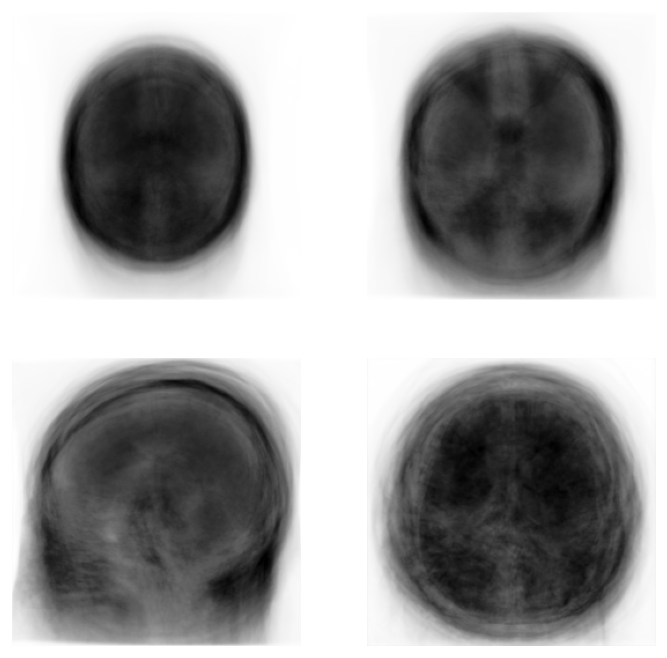

In [26]:
fig, ax = plt.subplots(2,2,figsize=(7,7),dpi=120)
for i,j in zip(a,A[0]):
        ax[i[0]][i[1]].imshow(j.reshape(250,250))
        ax[i[0]][i[1]].set_axis_off()
plt.show()

El patrón naïve que encontramos fue la forma y la toma del MRI. 

In [27]:
dummy = {'img':All_data,'cat':A[1]}

In [28]:
df = pd.DataFrame(dummy)

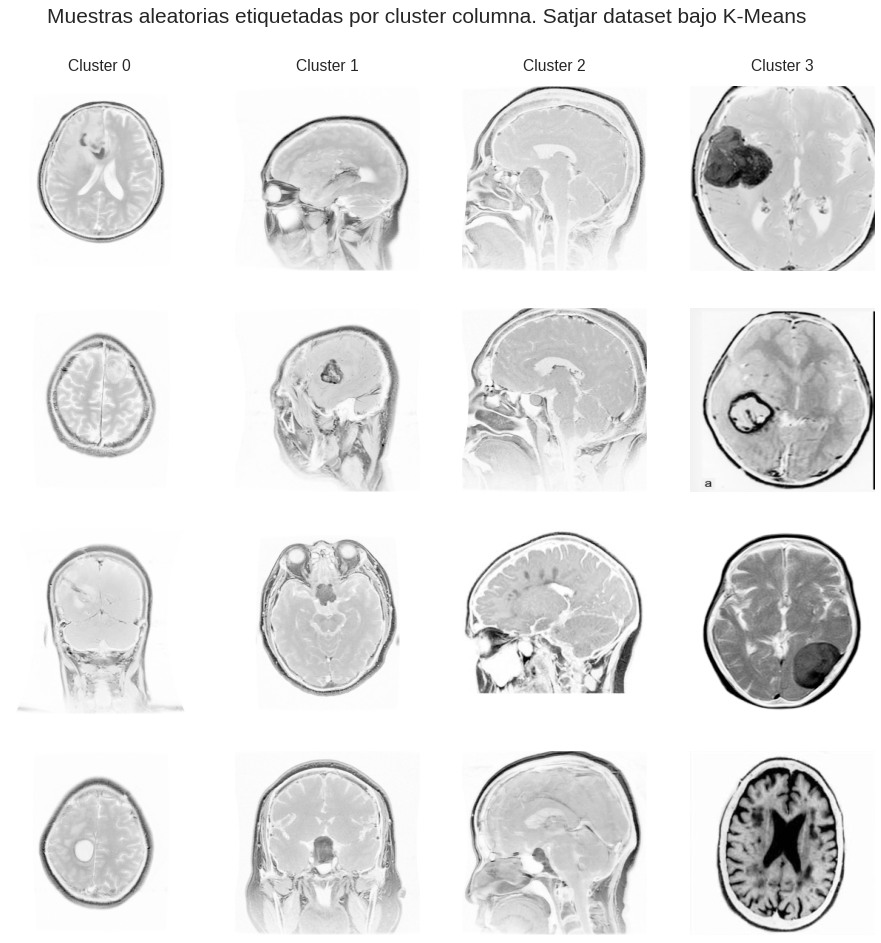

In [33]:
fig, ax = plt.subplots(4,4,figsize=(15,15),dpi=75)
for i in range(4):
    for j,im in enumerate(df[df.cat == i+1].sample(n=4).values):
        ax[j,i].imshow(im[0].reshape(250,250))
        #ax[j,i].set_title(i)
        ax[j,i].set_axis_off()
        ax[0][i].set_title('Cluster {}'.format(i),fontsize=15).set_position([.5, 1.05])
        
fig.suptitle('Muestras aleatorias etiquetadas por cluster columna. Satjar dataset bajo K-Means',y=0.95,fontsize=20)
        
plt.show()

Notemos que K-Means puede ver carecteristicas que para nuestro problema son en sí mismas macro. En lugar de captar las caracteristias relacionadas a la aparición de un tumor toma aquellas relacionadas a las de la forma en que la MRI fue tomada (plano). 

Ahora, vamos a desarrollar un modelo pequeño de CNN para realizar una clasificación multiclase exploratoria ¿Qué dificultades tendrémos en obtener un modelo con un buen accurracy?

In [35]:
def set_seed(seed=1):
    """
    Esta función la seteamos para poder asegurar la reproducibilidad de nuestros
    resultados al futuro
    """
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

Ahora, podemos usar la función que previamente creamos pero deberíamos crear una función para poder etiquetar ahora nuestros datos, por lo pronto voy a usar `image_dataset_from_directory` para poder leer los sets de entrenamiento

In [74]:
ds_train_ = image_dataset_from_directory(
    MAINFOLDER,
    labels='inferred',
    label_mode='categorical',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
    color_mode="grayscale"
)

Found 2870 files belonging to 4 classes.


In [75]:
ds_valid_ = image_dataset_from_directory(
    MAINFOLDER.replace('Training','Testing'),
    labels='inferred',
    label_mode='categorical',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
    color_mode="grayscale"
)

Found 394 files belonging to 4 classes.


In [1]:
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE #Para mejor auto better performance

#Cargamos los sets y usamos cache
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

NameError: name 'tf' is not defined

In [77]:
ds_train_.map(convert_to_float).map(lambda x,y:(tf.reshape(x,[-1,128,128,1]),y))

<MapDataset shapes: ((None, 128, 128, 1), (None, 4)), types: (tf.float32, tf.float32)>

In [82]:
model = keras.Sequential([
    # Block One
    layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same',
                  input_shape=[128, 128, 1]),
    layers.MaxPool2D(),

    # Block Two
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    #layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Block Three
    # YOUR CODE HERE
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Head
    layers.Flatten(),
    layers.Dense(60, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(4, activation='softmax'),
])

In [79]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 128)       147584    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 128)      

In [84]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
    # YOUR CODE HERE: Add loss and metric
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

In [85]:
history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=50,
)

Epoch 1/50
45/45 [==============================] - 56s 1s/step - loss: 1.3748 - accuracy: 0.2892 - val_loss: 1.4270 - val_accuracy: 0.2208
Epoch 2/50
45/45 [==============================] - 60s 1s/step - loss: 1.2820 - accuracy: 0.4412 - val_loss: 1.6541 - val_accuracy: 0.2437
Epoch 3/50
45/45 [==============================] - 60s 1s/step - loss: 1.1064 - accuracy: 0.5129 - val_loss: 1.9411 - val_accuracy: 0.2335
Epoch 4/50
45/45 [==============================] - 60s 1s/step - loss: 0.9966 - accuracy: 0.5739 - val_loss: 2.0837 - val_accuracy: 0.3274
Epoch 5/50
45/45 [==============================] - 57s 1s/step - loss: 0.8413 - accuracy: 0.6476 - val_loss: 2.2304 - val_accuracy: 0.3198
Epoch 6/50
45/45 [==============================] - 58s 1s/step - loss: 0.7595 - accuracy: 0.7066 - val_loss: 2.4993 - val_accuracy: 0.3452
Epoch 7/50
45/45 [==============================] - 58s 1s/step - loss: 0.6914 - accuracy: 0.7178 - val_loss: 2.4299 - val_accuracy: 0.4112
Epoch 8/50
45/45 [==

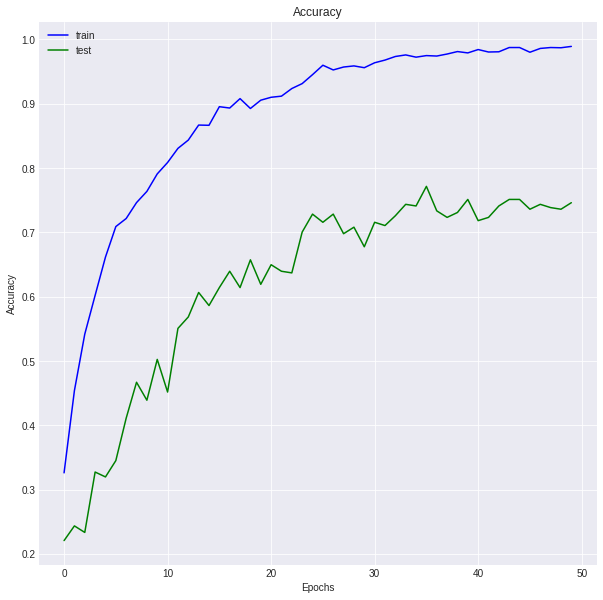

In [87]:
plt.plot(history.history["accuracy"],c = "blue")
plt.plot(history.history["val_accuracy"],c = "green")
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.rcParams["figure.figsize"] = (50,50)
plt.legend(["train", "test"])